In [15]:
import sys
sys.path.append("../../../")
import utilssphering
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.stats
import itertools

In [ ]:
match_rep_df = pd.read_csv("../checkpoints/match_rep_df.csv")

match_rep_df = match_rep_df[match_rep_df["sphering"] == True]

match_rep_df

In [ ]:
# Compare all possible pairs of plates

profile_path = "../../jump-scope/profiles/"

def combination_compare(match_rep_df: pd.DataFrame, vendor: str, profile_path, no_difference_cols: list = ["Magnification", "Binning"]):
    """
    For a given vendor, find all possible pariwise plate comparisons and perform
    the KSTest between all features.

    Returns a dataframe with KSTest statistic and pvalues for each feature.
    Returned DataFrame also includes setting information for each plate (column
    appended with plate1 or plate2, accordingly.)

    no_difference_cols: if the plates to be compared differ in these values,
    they will be skipped. For example, 20x will not be compared with 10x
    """
    vendor_subset = match_rep_df[
        match_rep_df["Vendor"].str.contains(vendor, case=False) &
        ~match_rep_df["Batch"].str.contains("sitesub", case=False) # Exclude sitesub
    ]

    # Find plate combinations 
    # Since we use with replacement, make sure to drop identical comparisons later
    plate_combinations = itertools.combinations_with_replacement(vendor_subset["Assay_Plate_Barcode"].to_list(), 2)

    # df to store results
    collated_df = pd.DataFrame()

    for i in plate_combinations:
        left_row = vendor_subset[vendor_subset["Assay_Plate_Barcode"] == i[0]].reset_index()
        right_row = vendor_subset[vendor_subset["Assay_Plate_Barcode"] == i[1]].reset_index()
        # Check that profiles posses the same values in the no_difference_cols columns
        if no_difference_cols is not None:
            if not left_row[no_difference_cols].equals(right_row[no_difference_cols]):
                print(f"""Skipping {left_row[no_difference_cols].values} vs {right_row[no_difference_cols].values} between {i}""")
                continue

        # Load profiles
        left_path = os.path.join(profile_path, left_row["Batch"].values[0], left_row["Assay_Plate_Barcode"].values[0], f"{left_row['Assay_Plate_Barcode'].values[0]}.csv.gz")
        left_profile = pd.read_csv(left_path)
        right_path = os.path.join(profile_path, right_row["Batch"].values[0], right_row["Assay_Plate_Barcode"].values[0], f"{right_row['Assay_Plate_Barcode'].values[0]}.csv.gz")
        right_profile = pd.read_csv(right_path)

        print(f"Comparing {left_row['Batch'].values[0]}/{i[0]} with {right_row['Batch'].values[0]}/{i[1]}")

        # Drop string columns
        left_profile_cols = left_profile.select_dtypes(include=['object'])
        left_profile = left_profile.drop(columns=left_profile_cols.columns)
        left_profile = left_profile.loc[:, ~left_profile.columns.str.contains("metadata", case=False)]

        right_profile_cols = right_profile.select_dtypes(include=['object'])
        right_profile = right_profile.drop(columns=right_profile_cols.columns)
        right_profile = right_profile.loc[:, ~right_profile.columns.str.contains("metadata", case=False)]

        # Gather settings for plate1 and plate2 to add to the same row with the corresponding statistic
        left = vendor_subset[vendor_subset["Assay_Plate_Barcode"] == i[0]]
        left = left.add_suffix("_plate1").reset_index(drop=True)
        right = vendor_subset[vendor_subset["Assay_Plate_Barcode"] == i[1]]
        right = right.add_suffix("_plate2").reset_index(drop=True)
        comparison_df = pd.concat([left, right], axis=1)

        for feature in left_profile.columns.intersection(right_profile.columns):
            kstest_comparison = scipy.stats.kstest(left_profile[feature].values, right_profile[feature].values)
            new_cols = pd.DataFrame.from_dict({
                f"{feature}_kstest_statistic": [kstest_comparison[0]],
                f"{feature}_kstest_pvalue": [kstest_comparison[1]]
            })
            # Append plate_comparison statistics as a column
            comparison_df = pd.concat([comparison_df, new_cols], axis=1)

        # Append two plate comparison as a new row
        collated_df = pd.concat([collated_df, comparison_df], axis=0)
    
    return collated_df

for vend in match_rep_df["Vendor"].unique():
    print(vend)
    if os.path.isfile(f"{vend}_all_plate_comparison_exclude_different_mag_binning_comparison.csv"):
        continue
    comb_df = combination_compare(match_rep_df, vend, profile_path, no_difference_cols=["Magnification", "Binning"])
    comb_df.to_csv(f"{vend}_all_plate_comparison_exclude_different_mag_binning_comparison.csv", index=False)


In [16]:
def format_value(value):
    if isinstance(value, str):
        return value
    elif abs(value) < 1e-3 or abs(value) >= 1e5:
        return '{:.3e}'.format(value)
    else:
        return '{:.3f}'.format(value)

def top_bottom_features(df: pd.DataFrame, num: int = 10):
    # Drop columns that we don't need
    drop_cols = df.columns[df.columns.str.contains("kstest_statistic|_Location_|Children|Parent|Number_Object")]

    df = df.drop(columns=drop_cols)

    # pvalues are determined between all combinations with replacement, so remove the 
    # identical comparisons
    df = df[df["Assay_Plate_Barcode_plate1"] != df["Assay_Plate_Barcode_plate2"]]

    compartments = ["Nuclei", "Cytoplasm", "Cells"]

    result_df = pd.DataFrame()

    for compart in compartments:
        subset_cols = [col for col in df.columns if compart in col]
        sub_df = df[subset_cols]
        # print(sub_df.columns)

        # Find the first 3 words of column names that will be used for grouping
        group_words = [col.split("_")[:3] for col in subset_cols]
        # Join them back
        group_words = ["_".join(w) for w in group_words]

        # Find the mean for the feature groups
        result_df = pd.concat([result_df, sub_df.groupby(group_words, axis=1).mean().mean(axis=0).reset_index()])

    result_df = result_df.rename(columns={"index": "Feature", 0: "pvalue"})

    top_features = result_df.sort_values(by="pvalue", ascending=False).reset_index(drop=True)[:num]

    bottom_features = result_df.sort_values(by="pvalue")[:num].reset_index(drop=True)

    t_b_feats = pd.concat([top_features, bottom_features], axis=1)

    # Format the numbers after the decimal point
    t_b_feats = t_b_feats.applymap(format_value)

    t_b_feats.insert(0, "", np.arange(1, num+1))

    return t_b_feats

def plot_tables(top_features, bottom_features, plot_title, fig, ax):
    assert len(ax) == 2, "ax must have two columns"

    table1 = ax[0].table(cellText=top_features.values, colLabels=top_features.columns, loc='center', cellLoc='center')
    table2 = ax[1].table(cellText=bottom_features.values, colLabels=bottom_features.columns, loc='center', cellLoc='center')

    ax[0].axis('off')
    ax[1].axis('off')

    ax[0].set_title("Least sensitive features", size=15)
    ax[1].set_title("Most sensitive features", size=15)

    for key, cell in table1.get_celld().items():
        if key[0] == 0 or key[1] == -1:
            text = table1._cells[key].get_text()
            text.set_fontweight('bold')
            text.set_fontsize(12)

    for key, cell in table2.get_celld().items():
        if key[0] == 0 or key[1] == -1:
            text = table2._cells[key].get_text()
            text.set_fontweight('bold')
            text.set_fontsize(12)

    table1.auto_set_font_size(False)
    table2.auto_set_font_size(False)
    table1.auto_set_column_width(col=list(range(len(top_features.columns))))
    table2.auto_set_column_width(col=list(range(len(bottom_features.columns))))

    table1.get_celld()[(0, 0)].set_linewidth(0)
    table2.get_celld()[(0, 0)].set_linewidth(0)

    table1.scale(1.5, 1.5)
    table2.scale(1.5, 1.5)
    fig.tight_layout(rect=[0, 0, 1, 0.93])
    fig.set_facecolor("white")
    fig.suptitle(plot_title, fontsize=20)

    return fig

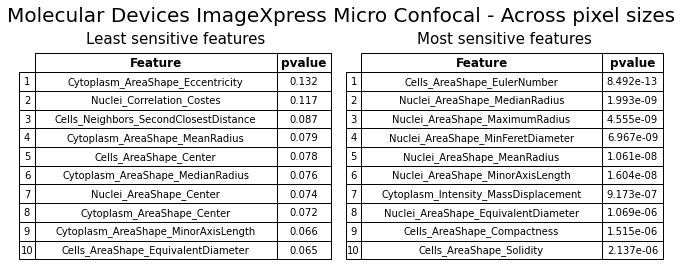

In [24]:
df = pd.read_csv("../../../data/MolDev_all_plate_comparison.csv")
t_b_feats = top_bottom_features(df)
fig, ax = plt.subplots(1, 2, figsize=(9.3, 3.8))
plot = plot_tables(t_b_feats.iloc[:,[0,1,2]], t_b_feats.iloc[:, [0,3,4]], "Molecular Devices ImageXpress Micro Confocal - Across pixel sizes", fig, ax)
# plot.savefig("(S9A1)-moldev-across-pixel-size.png", dpi=300)

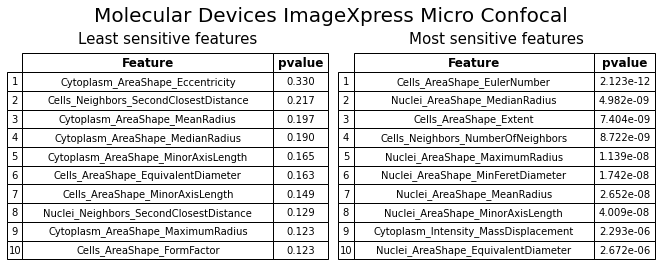

In [25]:
df = pd.read_csv("../../../data/MolDev_all_plate_comparison_exclude_different_mag_binning_comparison.csv")
t_b_feats = top_bottom_features(df)
fig, ax = plt.subplots(1, 2, figsize=(9.3, 3.8))
plot = plot_tables(t_b_feats.iloc[:,[0,1,2]], t_b_feats.iloc[:, [0,3,4]], "Molecular Devices ImageXpress Micro Confocal", fig, ax)
plot.savefig("(S9A)-moldev-same-pixel-size.png", dpi=300)

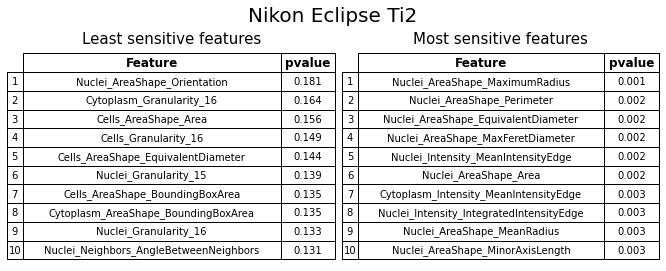

In [26]:
df = pd.read_csv("../../../data/Nikon_all_plate_comparison.csv")
t_b_feats = top_bottom_features(df)
fig, ax = plt.subplots(1, 2, figsize=(9.3, 3.8))
plot = plot_tables(t_b_feats.iloc[:,[0,1,2]], t_b_feats.iloc[:, [0,3,4]], "Nikon Eclipse Ti2", fig, ax)
# plot.savefig("(S9B1)-nikon-across-pixel-size.png", dpi=300)

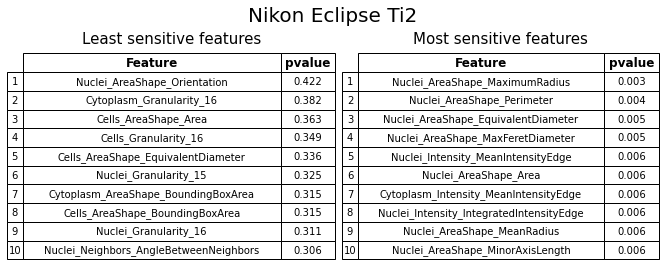

In [27]:
df = pd.read_csv("../../../data/nikon_all_plate_comparison_exclude_different_mag_binning_comparison.csv")
t_b_feats = top_bottom_features(df)
fig, ax = plt.subplots(1, 2, figsize=(9.3, 3.8))
plot = plot_tables(t_b_feats.iloc[:,[0,1,2]], t_b_feats.iloc[:, [0,3,4]], "Nikon Eclipse Ti2", fig, ax)
plot.savefig("(S9B)-nikon-same-pixel-size.png", dpi=300)

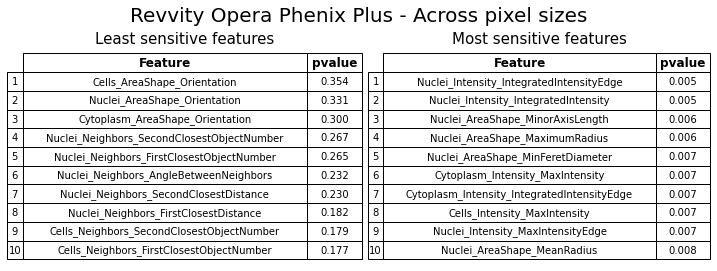

In [28]:
df = pd.read_csv("../../../data/PE_all_plate_comparison.csv")
t_b_feats = top_bottom_features(df)
fig, ax = plt.subplots(1, 2, figsize=(10, 3.8))
plot = plot_tables(t_b_feats.iloc[:,[0,1,2]], t_b_feats.iloc[:, [0,3,4]], "Revvity Opera Phenix Plus - Across pixel sizes", fig, ax)
# plot.savefig("(S9C1)-pe-across-pixel-size.png", dpi=300)

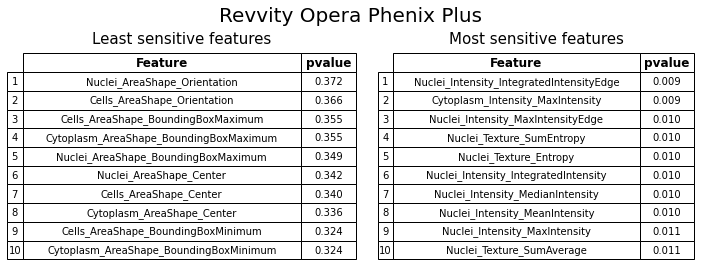

In [29]:
df = pd.read_csv("../../../data/PE_all_plate_comparison_exclude_different_mag_binning_comparison.csv")
t_b_feats = top_bottom_features(df)
fig, ax = plt.subplots(1, 2, figsize=(10, 3.8))
plot = plot_tables(t_b_feats.iloc[:,[0,1,2]], t_b_feats.iloc[:, [0,3,4]], "Revvity Opera Phenix Plus", fig, ax)
plot.savefig("(S9C)-pe-same-pixel-size.png", dpi=300)

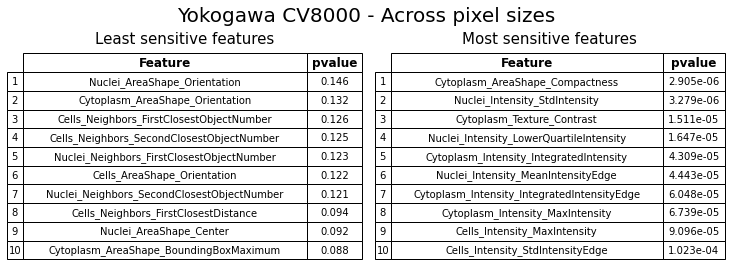

In [30]:
df = pd.read_csv("../../../data/yokogawa_us_all_plate_comparison.csv")
t_b_feats = top_bottom_features(df)
fig, ax = plt.subplots(1, 2, figsize=(10.3, 3.8))
plot = plot_tables(t_b_feats.iloc[:,[0,1,2]], t_b_feats.iloc[:, [0,3,4]], "Yokogawa CV8000 - Across pixel sizes", fig, ax)
# plot.savefig("(S9D1)-yokogawa_us-across-pixel-size.png", dpi=300)

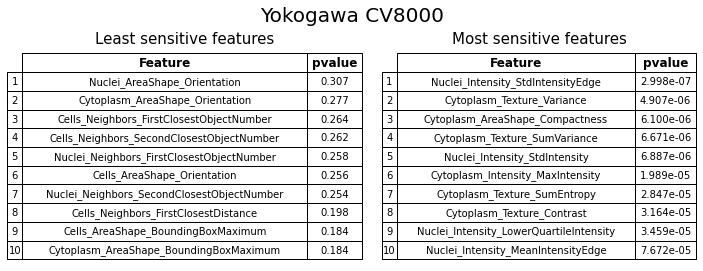

In [31]:
df = pd.read_csv("../../../data/yokogawa_us_all_plate_comparison_exclude_different_mag_binning_comparison.csv")
t_b_feats = top_bottom_features(df)
fig, ax = plt.subplots(1, 2, figsize=(10, 3.8))
plot = plot_tables(t_b_feats.iloc[:,[0,1,2]], t_b_feats.iloc[:, [0,3,4]], "Yokogawa CV8000", fig, ax)
plot.savefig("(S9D)-yokogawa_us-same-pixel-size.png", dpi=300)

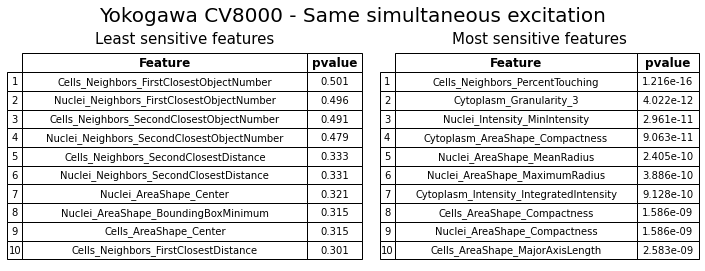

In [33]:
df = pd.read_csv("../../../data/Yokogawa_US_all_plate_comparison_exclude_different_mag_binning_comparison_exclude_simultaneous_excitation.csv")
t_b_feats = top_bottom_features(df)
fig, ax = plt.subplots(1, 2, figsize=(10, 3.8))
plot = plot_tables(t_b_feats.iloc[:,[0,1,2]], t_b_feats.iloc[:, [0,3,4]], "Yokogawa CV8000 - Same simultaneous excitation", fig, ax)
plot.savefig("(S9E)-yokogawa_us-same-pixel-size-same-simultenaous excitation.png", dpi=300)